# Creating your own dataset from BING Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [1]:
from fastai.vision import *

### Use icrwaler to download data

In [ ]:
!pip install icrawler

In [ ]:
from icrawler.builtin import (BingImageCrawler, GoogleImageCrawler)
import logging

In [ ]:
path = Path('data/lily')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='peace lily', filters=None, offset=0, max_num=1000)

In [ ]:
path = Path('data/benjamina')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='ficus benjamina', filters=None, offset=0, max_num=1000)

In [ ]:
path = Path('data/elastica')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='ficus elastica', filters=None, offset=0, max_num=1000)

In [ ]:
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='peace lily', filters=None, offset=100, max_num=1000)

Then we can remove any images that can't be opened:

In [2]:
path=Path('data')
path

PosixPath('data')

In [3]:
classes = ['elastica','benjamina','lily']

In [4]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

elastica


benjamina


lily


tuple index out of range


## View data

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [6]:
data.classes

['benjamina', 'elastica', 'lily']

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['benjamina', 'elastica', 'lily'], 3, 1227, 306)

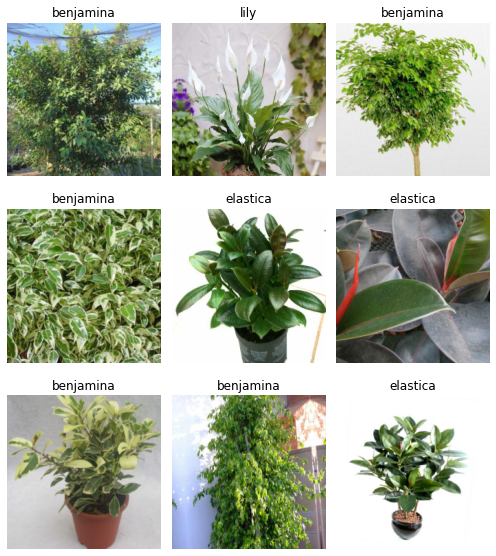

In [8]:
data.show_batch(rows=3, figsize=(7,8))

## Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [ ]:
!pip install --upgrade --force-reinstall ipywidgets

In [ ]:
!pip install --upgrade --force-reinstall widgetsnbextension 

In [ ]:
!jupyter nbextension install --py widgetsnbextension

In [ ]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
path = Path('data')
path

In [ ]:
img = open_image(path/'Test'/'IMG_0082.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class